```
Created on Jan 23, 2019
将来的なh-index予測を行う
h-indexの定義
h-index(f) = max_i min (f(i),i)

@author: ochi
```

In [1]:
import collections as cl
import codecs
import sys
import matplotlib

import matplotlib.pyplot as plt
import sklearn.model_selection as sms
import os
import shutil
import csv
import random
import numpy as np
import sklearn.linear_model as slm
import sklearn.metrics as smt
import sklearn.metrics.pairwise as smp
import sklearn.neighbors as sn
import scipy.stats as ss
import seaborn as sns


In [2]:
def decidePth(yDic, probDic, pths=[i/100.0 for i in range(1000)]):
    pthDic = {}
    for label in probDic.keys():
        pthfscores = []
        for pth in pths:
            plabels = []
            for prob in probDic[label]:
                if prob >= pth:
                    plabels.append(1)
                else:
                    plabels.append(0)

            (precision, recall, fscore, support) = smt.precision_recall_fscore_support(yDic[label], plabels, average="binary")
            pthfscores.append((pth,fscore))

        pthfscores.sort(key=lambda x:-x[1])
        
        best_pth = pthfscores[0][0]
        best_fscore = pthfscores[0][1]
        print("%s:best pth=%.3f,fscore=%.3f"%(label,best_pth,best_fscore))
        pthDic[label] = best_pth

    return pthDic

In [3]:
def drawPRCMulti(yDic,probDic):

    num_c = 24
    linestyles = ['-','--','-.',':']
    palette = sns.color_palette("colorblind",num_c)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    lw = 2

    for i, name in enumerate(probDic.keys()):
#        print(name)
        probs = probDic[name]
        y     = yDic[name]
#        print(y)
#        print(set(probs))
#        precision, recall, thresholds = smt.precision_recall_curve(y,probs)
#        ax.step(recall, precision, color=palette[i%num_c], alpha=0.8, where='post', label=name, lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])

        if len(set(probs)) > 2:
            precision, recall, thresholds = smt.precision_recall_curve(y,probs)
            ax.step(recall, precision, color=palette[i%num_c], alpha=0.8, where='post', label=name, lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])
        else:
            precision = smt.precision_score(y,probs)
            recall    = smt.recall_score(y,probs)
            ax.step(recall, precision, 'x', color=palette[i%num_c], alpha=0.8, where='post', label=name, lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])

        print(name)
        print("precision")
        print(precision)
        print("recall")
        print(recall)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall Rate')
    ax.set_ylabel('Precision Rate')
    ax.set_title('h-index Prediction Precision-Recall Results')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.04,1.0))

    fig.savefig("hindex_prediction_precision_recall_curve_many_results.pdf", dpi=100, bbox_extra_artists=(lgd,), bbox_inches='tight')
#    fig.clf()
#    plt.close()

    return

In [4]:
def readVectorFilesJoint(vec_files, delimiter=' '):
    vecDics = []
    set_nodes = set([])
    for vec_file in vec_files:
        vecDic = readVectorFile(vec_file)
        vecDics.append(vecDic)
        if len(set_nodes) == 0:
            set_nodes = set(vecDic.keys())
        else:
            set_nodes &= set(vecDic.keys())

    m_vecDic = {}
    for node in list(set_nodes):
        new_vec = []
        for vecDic in vecDics:
            vec = vecDic[node]
            new_vec = np.append(new_vec,vec)

        m_vecDic[node] = new_vec

    return m_vecDic


In [5]:
def readVectorFile(vec_file, delimiter=' '):
    vecDic = {}
    with open(vec_file, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for i, row in enumerate(reader):
            if i == 0:
                # header line
                continue
            else:
                node = row[0]
                vec = np.array(row[1:-1],dtype=np.float)
                vecDic[node] = vec
            pass
    return vecDic

In [6]:
cv=0
order='1'
itr='3000'
rho='0.05'
th="0.001000"

train_file   = "../../scopus_xml_scraper/csv01/top%sornot_hindex2013.csv"%(th)
test_file    = "../../scopus_xml_scraper/csv01/top%sornot_hindex2016.csv"%(th)
compare_results_file    = "../../scopus_xml_scraper/csv01/top%sornot_hindex2013.csv"%(th)

selectedauthors_file = "../../scopus_xml_scraper/csv01/select10authors_hindex2009.csv"

vectorfileDic = {
    "non_2009":"../res01sample_linkprd_new_sel1_normalized/non_all_vec_%s_%sst_%s_%s_wo_norm_until2009.txt"%(cv,order,itr,rho),
    "non_2013":"../res01sample_linkprd_new_sel1_normalized/non_all_vec_%s_%sst_%s_%s_wo_norm_until2013.txt"%(cv,order,itr,rho),
}
        


In [7]:
def makeMTXData(labelDic,vecDic,selected_authors,ref_aids=[]):
    xs = []
    ys = []
    vec_keys = set(vecDic.keys())
   
    selected_aids = []
    if len(ref_aids) == 0:
        aids = list(set(vecDic.keys())&set(labelDic.keys()))
    else:
        aids = ref_aids

    for i, aid in enumerate(aids):
        if aid not in vec_keys:
            continue

        selected_aids.append(aid)

        au_vec = vecDic[aid]
        distances = []
        label = labelDic[aid]
        for t_id in selected_authors:
            t_vec = vecDic[t_id]
#            distance = smp.cosine_distances([au_vec],[t_vec])[0,0]
            distance = smp.cosine_similarity([au_vec],[t_vec])[0,0]
            distances.append(distance)

#        a_x = distances
        # 近い順に並べてみる
        distances = sorted(distances, key=lambda x:-x)
        distances.append(float(label)) #特徴量に訓練させるラベルをまさかの追加
        a_x = distances
#        a_x = au_vec
        xs.append(a_x)
        y = int(labelDic[aid])
        ys.append(y)

    print("cos sim sorted")
    print(set(ys))
    y = np.array(ys, dtype=np.int).reshape((len(ys),1))
    print(y.shape)
    x = np.array(xs, dtype=np.float)
    print(x.shape)
    return x, y, selected_aids

In [8]:
def calc_distances(s_vec,t_vec):
    distances = []
    x = [s_vec,t_vec]
    a_dist = calcADist(x,"euclidean")
    distances.append(a_dist)
    a_dist = calcADist(x,"manhattan")
    distances.append(a_dist)
    a_dist = calcADist(x,"chebyshev")
    distances.append(a_dist)
#    a_dist = calcADist(x,"minkowski")
#    distances.append(a_dist)
#    a_dist = calcADist(x,"wminkowski")
#    distances.append(a_dist)
#    a_dist = calcADist(x,"seuclidean")
#    distances.append(a_dist)
#    a_dist = calcADist(x,"mahalanobis")
#    distances.append(a_dist)
    return distances

In [9]:
def calcADist(x,mode="euclidean"):
    dist = sn.DistanceMetric.get_metric(mode)
    a_dist = dist.pairwise(x)[0,1]
    return a_dist

In [10]:
def readLabeledFile(afile, delimiter=','):
    labelDic = {}
    with open(afile, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for i, row in enumerate(reader):
            aid = row[0]
            label = row[1]
            labelDic[aid] = label

    return labelDic

In [11]:
def readSelectedAuthorsFile(filepath,delimiter=','):
    authors = []
    with open(filepath, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        for i, row in enumerate(reader):
            aid = row[0]
            authors.append(aid)

    return authors

In [12]:
cv=0
order='1'
itr='3000'
rho='0.05'
th="0.001000"

train_file   = "../../scopus_xml_scraper/csv01/top%sornot_hindex2013.csv"%(th)
test_file    = "../../scopus_xml_scraper/csv01/top%sornot_hindex2016.csv"%(th)
compare_results_file    = "../../scopus_xml_scraper/csv01/top%sornot_hindex2013.csv"%(th)

selectedauthors_file = "../../scopus_xml_scraper/csv01/select10authors_hindex2009.csv"

vectorfileDic = {
    "non_2009":"../res01sample_linkprd_new_sel1_normalized/non_all_vec_%s_%sst_%s_%s_wo_norm_until2009.txt"%(cv,order,itr,rho),
    "non_2013":"../res01sample_linkprd_new_sel1_normalized/non_all_vec_%s_%sst_%s_%s_wo_norm_until2013.txt"%(cv,order,itr,rho),
}
        


In [13]:
selected_authors = readSelectedAuthorsFile(selectedauthors_file)
train_labelDic = readLabeledFile(train_file)
test_labelDic  = readLabeledFile(test_file)
compare_labelDic = readLabeledFile(compare_results_file)


In [14]:

test_probDic={}
test_yDic={}
train_vec_file = vectorfileDic["non_2009"]
train_vecDic = readVectorFile(train_vec_file)

print("complete getting train vectors")

complete getting train vectors


In [15]:
test_vec_file = vectorfileDic["non_2013"]
test_vecDic = readVectorFile(test_vec_file)

train_aids = list(set(train_vecDic.keys())&set(train_labelDic.keys()))
print(len(train_aids))
print(len(list(set(test_vecDic.keys()))))
test_aids  = list(set(test_vecDic.keys()) & set(test_labelDic.keys()) & set(compare_labelDic.keys()))
selected_authors = list(set(train_aids)&set(test_aids)&set(selected_authors))

print("complete getting test vectors")


87012
3179042
complete getting test vectors


In [16]:
train_x, train_y, train_aids =  makeMTXData(train_labelDic,train_vecDic,selected_authors,train_aids)
print("complete making train_xy")


cos sim sorted
{0, 1}
(87012, 1)
(87012, 11)
complete making train_xy


In [17]:
def getCompareResults(aids,compare_results_file):
    compare_labelDic = readLabeledFile(compare_results_file)
    test_compare_res = []
    for aid in aids:
        label = int(compare_labelDic[aid])
#        if label == 0:
#            label = -0.1
#        elif label == 1:
#            label = 1.1
        test_compare_res.append(label)

    return test_compare_res

In [18]:
test_compare_res = getCompareResults(test_aids, compare_results_file)
comp_labelDic = {}
for i,aid in enumerate(test_aids):
    comp_labelDic[aid] = test_compare_res[i]


In [19]:
test_x,  compare_y,  test_aids  =  makeMTXData(compare_labelDic,test_vecDic,selected_authors,test_aids)
print("complete making test_xy")

tys = []
for aid in test_aids:
    l = test_labelDic[aid]
    tys.append(l)
    
test_y = np.array(tys, dtype=np.int).reshape((len(tys),1))


cos sim sorted
{0, 1}
(142000, 1)
(142000, 11)
complete making test_xy


In [26]:
print(len(test_aids))

142000


In [21]:
model = slm.LogisticRegression(penalty='l2',tol=1e-6,C=1.0,warm_start=True)
model.fit(train_x, train_y)
print("complete lr model fit")
print("lr model weightsk")
print(model.coef_[0,:])

test_probs = model.predict_proba(test_x)[:,1]

#for i, p in enumerate(test_probs):
#    print("%s,prob:%f,y:%d"%(test_aids[i],p,test_y[i][0]))
        
print("complete lr model predict")

/home/jovyan/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/jovyan/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


complete lr model fit
lr model weightsk
[ 0.57722177  0.46561461  0.45455191  0.4567382   0.50011677  0.40014516
  0.46727519  0.52775805  0.61080594  0.7118756  11.1474177 ]
complete lr model predict


In [22]:
import random


test_compare_res = getCompareResults(test_aids, compare_results_file)
test_compare_res1 = []
for res in test_compare_res:
    if res == 0:
        n_res = 0.25
    else:
        n_res = 0.75
    n_res += (random.random()-0.5)/2.0
    test_compare_res1.append(n_res)

test_probDic["non_2013"] = test_probs

test_probDic["hindex2013"] = [float(ele) for ele in test_compare_res1]
#test_probDic["random"] = [random.random() for i in range(test_y.shape[0])]
test_yDic["non_2013"]    = test_y
#test_yDic["random"]    = test_y
test_yDic["hindex2013"]    = test_y

print("Complete: %s LogisticRegression"%("non_1st2013"))


Complete: non_1st2013 LogisticRegression


In [23]:
def printPRF(yDic,probDic,pths=[i/100.0 for i in range(100)]):
    for pth in pths:
        for label in probDic.keys():
            plabels = []
            for prob in probDic[label]:
                if prob >= pth:
                    plabels.append(1)
                else:
                    plabels.append(0)

            (precision, recall, fscore, support) = smt.precision_recall_fscore_support(yDic[label], plabels, average="binary")
            print("pth=%.2f,method=%s,%f,%f,%f"%(pth,label,precision,recall,fscore))

    return

In [27]:

printPRF(test_yDic,test_probDic)


pth=0.00,method=non_2013,0.001810,1.000000,0.003613
pth=0.00,method=hindex2013,0.001810,1.000000,0.003613
pth=0.01,method=non_2013,0.756972,0.739300,0.748031
pth=0.01,method=hindex2013,0.001825,0.988327,0.003643
pth=0.02,method=non_2013,0.756972,0.739300,0.748031
pth=0.02,method=hindex2013,0.001861,0.988327,0.003716
pth=0.03,method=non_2013,0.756972,0.739300,0.748031
pth=0.03,method=hindex2013,0.001901,0.988327,0.003795
pth=0.04,method=non_2013,0.756972,0.739300,0.748031
pth=0.04,method=hindex2013,0.001935,0.984436,0.003862
pth=0.05,method=non_2013,0.756972,0.739300,0.748031
pth=0.05,method=hindex2013,0.001954,0.972763,0.003901
pth=0.06,method=non_2013,0.756972,0.739300,0.748031
pth=0.06,method=hindex2013,0.001999,0.972763,0.003989
pth=0.07,method=non_2013,0.756972,0.739300,0.748031
pth=0.07,method=hindex2013,0.002020,0.961089,0.004031
pth=0.08,method=non_2013,0.756972,0.739300,0.748031
pth=0.08,method=hindex2013,0.002033,0.945525,0.004058
pth=0.09,method=non_2013,0.756972,0.739300,0.7

non_2013
precision
[0.00270142 0.00269094 0.00269097 ... 1.         1.         1.        ]
recall
[1.         0.99610895 0.99610895 ... 0.0077821  0.00389105 0.        ]
hindex2013
precision
[0.00181032 0.00180329 0.0018033  ... 1.         1.         1.        ]
recall
[1.         0.99610895 0.99610895 ... 0.0077821  0.00389105 0.        ]


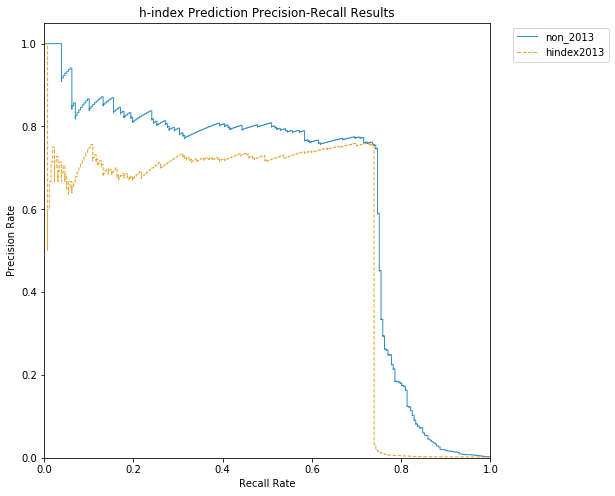

In [35]:

drawPRCMulti(test_yDic,test_probDic)


In [36]:
def drawROCMulti(yDic,probDic):
    num_c = 24
    linestyles = ['-','--','-.',':']
    palette = sns.color_palette("colorblind",num_c)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    lw = 2

    for i, name in enumerate(probDic.keys()):
        probs = probDic[name]
        y     = yDic[name]
        
        if len(set(probs)) > 2:
            fpr, tpr, thresholds = smt.roc_curve(y, probs)
            auc = smt.auc(fpr, tpr)
            ax.step(fpr, tpr, color=palette[i%num_c], alpha=0.8, where='post', label="%s:%.3f"%(name,auc), lw=lw*0.5, linestyle=linestyles[i%len(linestyles)])


    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Results')
    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.04,1.0))

    fig.savefig("hindex_roc_curve_many_results.pdf", dpi=100, bbox_extra_artists=(lgd,), bbox_inches='tight')
#    fig.clf()
#    plt.close()

    return

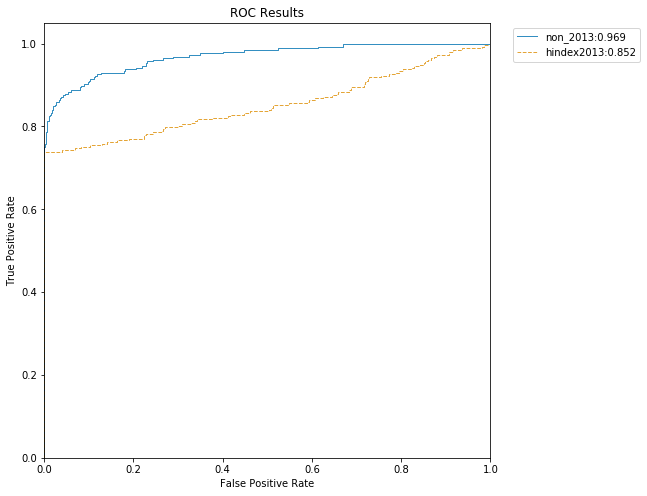

In [37]:
drawROCMulti(test_yDic,test_probDic)